<a href="https://colab.research.google.com/github/da3344ma-s-jpg/Lectures/blob/main/lectures/11-optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys, os
import matplotlib.pyplot as plt
import time
import matplotlib
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit, minimize
%matplotlib inline

# Repetition Functions:

Two ways to define functions:
* the classical way using def
* a more compact way is using a so-called lambda function that you use when you only want to define a function for one purpose (here optimizing)

## Definition syntax

In [17]:
def adding_one(s):
    """Function that returns s plus 1"""
    return s + 1

def adding_one_with_standard(s=5):
    """Function that returns s plus 1 and with a default value"""
    return s + 1

print(adding_one(5))
print(adding_one_with_standard(5))
print(adding_one_with_standard())

6
6
6


As we have learned before functions are so called namespaces in which we can re-use names we used outside. (remember _import this_ ?) <br>
this also means if you want to use something out of a function you have to return it.

## Task:

1. Write a function that takes `x`, `mu` and `sigma` and returns a gaussian bell curve (with normalisation). Make sure that you use numpy operations only, so that you can give it a vector and receive a vector.<br>
${\frac {1}{\sqrt {2\pi \sigma ^{2}}}}\operatorname {exp} \left(-{\frac {\left(x-\mu \right)^{2}}{2\sigma ^{2}}}\right)$<br>
(You should of course feel free to re-use your prior work)
2. define `mu=0` , `sigma=1` as standard inputs
3. create an x-vector (outside the function) from -5 to 5 in 0.01 steps and use the function to calculate the corresponding values of the gaussian
4. use the cumsum function from numpy to create the cummulative sum of the gaussian from above and normalize it with your lambda function
5. Put both y-vectors into a DataFrame with x as the index
6. Plot the output.

,Gaussian,Cumulative Sum
-5.00,0.000001,1.486720e-08
-4.99,0.000002,3.049588e-08
-4.98,0.000002,4.692340e-08
-4.97,0.000002,6.418885e-08
-4.96,0.000002,8.233318e-08


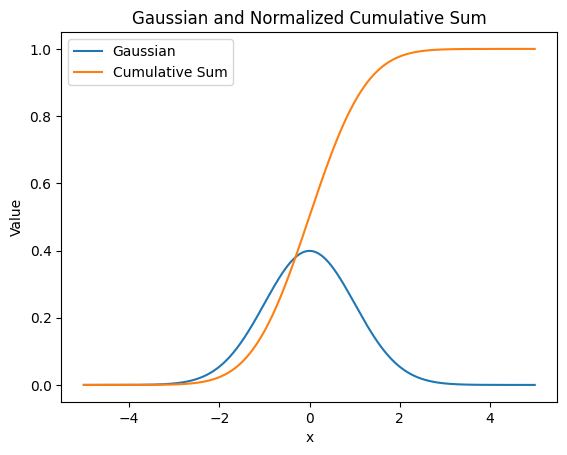

In [18]:
def gaussian(x, mu=0, sigma=1):
    """
    Function that returns a normalized gaussian bell curve.

    Args:
        x (np.ndarray): The input vector.
        mu (float, optional): The mean of the gaussian. Defaults to 0.
        sigma (float, optional): The standard deviation of the gaussian. Defaults to 1.

    Returns:
        np.ndarray: The gaussian values for the input x.
    """
    return (1 / np.sqrt(2 * np.pi * sigma**2)) * np.exp(-((x - mu)**2) / (2 * sigma**2))

# Create an x-vector
x = np.arange(-5, 5, 0.01)

# Calculate the corresponding values of the gaussian
y_gaussian = gaussian(x)

# Use the cumsum function from numpy to create the cummulative sum
y_cumulative = np.cumsum(y_gaussian)

# Normalize the cumulative sum using a lambda function
normalize = lambda arr: arr / arr[-1]
y_cumulative_normalized = normalize(y_cumulative)

# Put both y-vectors into a DataFrame with x as the index
df = pd.DataFrame({'Gaussian': y_gaussian, 'Cumulative Sum': y_cumulative_normalized}, index=x)
display(df.head())

# Plot the output
fig, ax = plt.subplots()
ax.plot(df.index, df['Gaussian'], label='Gaussian')
ax.plot(df.index, df['Cumulative Sum'], label='Cumulative Sum')
ax.set_xlabel('x')
ax.set_ylabel('Value')
ax.set_title('Gaussian and Normalized Cumulative Sum')
ax.legend()
plt.show()

# Optimisation in science
<div>
<img src="https://github.com/luchem/BioChemistry/blob/master/lectures/Data/KEMM30_007.png?raw=1" width="600">
</div>

How do you get there? or better,how do you get there without producing a lot of nonsense
Counting parameter. e.g. 10 peaks, each position, width, intensity =30 parameter plus background. So fitting is about intelligence. Think, $\textbf{optimize}$ the smallest amount of parameter starting with a good guess

One parameter optimisation (middle = mu)
<div>
<img src="https://github.com/luchem/BioChemistry/blob/master/lectures/Data/error_way.png?raw=1" width="1000">
</div>

<div>
<img src="https://github.com/luchem/BioChemistry/blob/master/lectures/Data/KEMM30_008.jpg?raw=1" width="700">
</div>



# Parameter optimisation: Fitting vs. optimisation

In science as in any research we try to make statements based upon our data. For this we need to extract these numbers from our data. To do this in a standardized way we "refine" a model function to our data.

In this course we will focus on three related methods to do that. In the advanced tasks below we will briefly mention a few more. The implementations of refining we will be looking into are:

1. **Curve Fit**<br>
   Curve fit is intended for exactly what the name says, fitting a single curve to data. Important is that the parameters are non dependent on each other. So think fitting a line, or a simple polynom.
2. **Scipy minimize**<br>
    Scipy minimize is a powerful function for optimization and the standard. It can use many minimization functions. It requires that we write a cost function. Parameter are handled as lists.
3. **LMfit**
    Is pretty much an "add-on" to scipy minimize. It has a number of special features, but we will focus on its parameter handling. As for scipy minimize you have to write a cost function. Parameter are however handled as dictionary type objects.


## Curve Fit
Starting with `curve_fit`. We assume that we have a flat function that has a clear gradient to the minimum (see top of this page) then we can use `curve_fit` to fast measure the parameter we need

In [ ]:
def decay(x, I0=1, lifetime=1):
    """ Exponential decay function """
    return I0 * np.exp(-x / lifetime)

# create some data with some randomness and plot it
x = np.linspace(0, 5, 200)
y = decay(x, I0=0.9, lifetime=1.1)
y += 0.5 * y * np.random.random(np.shape(x))

In [ ]:
# make a guess (starting values)
p0 = [0.8, 0.9]  # in order as in function

# optimise
popt, pcov = curve_fit(decay, xdata=x, ydata=y, p0=p0)

# plot both
fig, ax = plt.subplots()
ax.plot(x, y, "o", label="data")
ax.plot(x, decay(x, I0=p0[0], lifetime=p0[1]), "b-", label="guess")
ax.plot(x, decay(x, I0=popt[0], lifetime=popt[1]), "r-", label="fit")
ax.legend()

# get errors from the covariance matrix (works here, but careful)
perr = np.sqrt(np.diag(pcov))
df = pd.DataFrame({"values": popt, "errors": perr}, index=["I0", "lifetime"])
ax.text(x=2, y=0.4, s=df.to_string());

The key bit
```python
from scipy.optimize import curve_fit
popt,pcov = curve_fit(decay, xdata=x, ydata=y,p0=p0)
```
curve fit is a least square method that takes a function, the target data and a set of starting parameters, that are in order the parameter after the first.
it returns:
`popt = optimized` parameter
and
`pcov = covariance` matrix.
`p_sigma = np.sqrt(np.diag(pcov))`


<div>
<img src="https://github.com/luchem/BioChemistry/blob/master/lectures/Data/KEMM30_009.jpg?raw=1" width="800">
</div>

## Task:

1. Read the file `fit_0.csv`
2. Fit the peak in the file
3. plot both, data and fits:
4. What is the center position of the peak?

## Scipy minimize

Second way of optimisation uses in addition to the "cost function" an "error function". The task of the second function is to create a "price" for this parameter. The Minimize function is then minimizing this price.

### Parameter unpacking

Note how `*p` _unpacks_ the list into the positional function arguments.

In [ ]:
# redefine gauss to work with parameter vector p=mu,sigma,offset,scale
def gauss(x, mu=0, sigma=1, offset=0, scale=1):
    prefactor = 1 / np.sqrt(2 * np.pi * sigma**2)
    e_function = np.exp((-0.5 / sigma**2) * np.subtract(x, mu)**2)
    return prefactor * scale * e_function + offset


# create some data
x = np.linspace(-5, 5, 200)
p = [0.5, 0.5, 0, 1]
y = gauss(x, *p)
y += y * 0.5 * np.random.random(np.shape(x))

The new thing is that you need a second function that produces you a single "error" value

In [ ]:
def min_gauss(p, x, y):
    """Root mean square function"""
    return np.sqrt(
        ((y - gauss(x, *p))**2).sum()
    )

def min_gauss_lin(p, x, y):
    """
    This is a different cost function that uses a more linear approach.
    It does not "punish" strong deviations as much. As such it has the
    tendency to be more outlier stable but preforms bad for peaks.
    """
    return np.abs(y - gauss(x, *p)).sum()

In [ ]:
x0 = [0.6, 0.7, 0.1, 0.9]

# nelder-Mead is a standard multi-parameter optimiser. check out other choices:
out = minimize(min_gauss, x0=x0, args=(x, y), method="Nelder-Mead")
out2 = minimize(min_gauss_lin, x0=x0, args=(x, y), method="Nelder-Mead")

print(out)

compare the x vector and the x0 vector to see that the optimization has worked

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(x, y, "o", ms=5, label="data")
ax.set_xlabel("measured value")
ax.set_ylabel("occurance")
ax.plot(x, gauss(x, *x0), color="blue", lw=2, alpha=0.5, label="start")
ax.plot(x, gauss(x, *out["x"]), color="red", linestyle="dashed", lw=2, label="fit_sqrt")
ax.plot(x, gauss(x, *out2["x"]), color="green", lw=2, zorder=0, label="fit_lin")
ax.legend();

# Functions with dictionaries for parameter handling

While it is very useful to hand lists of parameters to a function it is very difficult to keep track of what parameter is where,
what it does and when it is updated. A good habbit is to define parameter with dictionaries or Pandas DataFrames.

In [ ]:
def gauss_with_names(x, par):  # the function that is your model
    """
    Gaussian type Peak function.

    Parameters:
    sigma and mu are mandatory, scale and offset are optional
    """

    pre_factor = 1 / np.sqrt(2 * np.pi * (par["sigma"]**2))
    exponent = (-0.5 / par["sigma"] ** 2) * (x - par["mu"])**2

    if "scale" in list(par.keys()):
        pre_factor *= par["scale"]
    if "offset" in list(par.keys()):
        return pre_factor * np.exp(exponent) + par["offset"]
    else:
        return pre_factor * np.exp(exponent)

def min_gauss(par, x, y):
    """The root mean square (we skip the root as the minimum is the minimum)"""
    return np.sqrt(((y - gauss_with_names(x, par)) ** 2).sum())

# LMFIT

While scipy minimize is a very useful tool, it is still a bit difficult to handle parameters (counting positions can produce errors). A very nice tool that was developed for this purpose is lmfit.



In [ ]:
!pip install lmfit
import lmfit

In [ ]:
# first create a parameter object
par = lmfit.Parameters()  # create empty parameter object

par.add("mu", value=0.4, vary=True)  # Add a parameter
par.add("sigma", value=0.5, vary=True)  # Add a parameter
par.add("scale", value=1, vary=True)  # Add a parameter

mini = lmfit.Minimizer(min_gauss, par, fcn_kws={"x": x, "y": y})  # Add a parameter
results = mini.minimize("nelder")
results

## Tasks:

1. Read the files
2. Fit files using either minimize or lmfit (or both if you want to train)
3. plot both: data and fits:

* `fit_0.csv`
* `fit_1.csv`  here: try first a separate fit, in which you fit the linear range and then separately the peak.
* `fit_3.csv` (two peaks and background)

In [ ]:
# We use pooch to import external data files from our Github repo
!pip install -q pooch
from pooch import retrieve
repo = "https://raw.githubusercontent.com/luchem/KEMM30/master/"

In [ ]:
path1 = retrieve(f"{repo}/lectures/Data/fit_0.csv", known_hash='a0f852c915d398d968059fd8ffbd7b7eeee9628b06e3c8f03817950eb358dbee')

In [ ]:
path2 = retrieve(f"{repo}/lectures/Data/fit_1.csv", known_hash='0fb5836ee33ab60af1efa001867f9075834e01ba613c4e8c1bce0da1f39401e6')

In [ ]:
path3 = retrieve(f"{repo}/lectures/Data/fit_3.csv", known_hash='6774c146a481ed9654e80821523d2031990bddc792c0404fd4b294fcd5f2cc45')

# Advanced
## Additional Modules to look into

1. **Statistical tools**<br>
    1. `scipy.stats` While there are a lot of statistical tools available in pandas and numpy, there are also some specialized tools for that.  scipy.stats offers you a wide range of tools for testing and correlation analysis        
    2. `statsmodels` offers a central API very similar to R and is pretty much the portation of R to python
2. **Numbers, constants, errors**
    1. `scipy.constants` <br>
    Numpy might contain some of the most used constants. this database however is specialized on providing all potential values.
    2. `uncertainties`<br>
    is a package that allows the calculation with numbers including error values. This tool takes care of all the error propagation.

3. **Biopython**<br>
    is a specialized suite for biological calculations and datahandling.

4. GUI<br>
    1. build in is TKinter. This is a standard platform that makes GUI maybe not nice, but easy
    2. QT is certainly the most powerful GUI generation tool, but not always the easiest
    3. pythonwx is a useful package
    
There is an endless number of very powerful calculation tools for pretty much any purpose. Before starting on a new I highly recommend to check how professional it is done. A good indication are extensive documentation, example use cases and very limited requirements (dependencies).
    